# Vision Transformer (ViT)|

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/pumpkin/Original/Original", transform=transform_train)

# Print dataset details
print("Classes:", dataset.classes)
print("Class-to-Index Mapping:", dataset.class_to_idx)

# Class distribution
labels = [sample[1] for sample in dataset.samples]
print("Class Distribution:", Counter(labels))



cuda
Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaf', 'Mosaic Disease', 'Powdery Mildew']
Class-to-Index Mapping: {'Bacterial Leaf Spot': 0, 'Downy Mildew': 1, 'Healthy Leaf': 2, 'Mosaic Disease': 3, 'Powdery Mildew': 4}
Class Distribution: Counter({0: 400, 1: 400, 2: 400, 3: 400, 4: 400})


In [3]:
# Dataset split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformations
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# Verify split sizes
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Vision Transformer (ViT) Model
class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            num_labels=num_classes
        )
    
    def forward(self, x):
        return self.vit(x).logits

# Initialize model
num_classes = len(dataset.classes)
model = ViTClassifier(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early stopping parameters
patience = 3  # Number of epochs with no improvement to wait
best_val_loss = float('inf')
early_stopping_counter = 0



Train Dataset Size: 1400
Validation Dataset Size: 400
Test Dataset Size: 200


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    global best_val_loss, early_stopping_counter

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        train_correct = 0

        print(f"Epoch {epoch + 1}/{epochs}")
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = 100.0 * train_correct / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = 100.0 * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            print("Validation loss improved. Resetting early stopping counter.")
        else:
            early_stopping_counter += 1
            print(f"No improvement in validation loss. Early stopping counter: {early_stopping_counter}/{patience}")
            if early_stopping_counter >= patience:
                print("Early stopping triggered. Stopping training.")
                break

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()




Epoch 1/10


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Train Loss: 0.8780, Train Accuracy: 75.86%
Val Loss: 0.5357, Val Accuracy: 86.00%

Validation loss improved. Resetting early stopping counter.
Epoch 2/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


Train Loss: 0.3928, Train Accuracy: 89.64%
Val Loss: 0.4714, Val Accuracy: 85.75%

Validation loss improved. Resetting early stopping counter.
Epoch 3/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Train Loss: 0.2640, Train Accuracy: 92.93%
Val Loss: 0.3824, Val Accuracy: 87.75%

Validation loss improved. Resetting early stopping counter.
Epoch 4/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


Train Loss: 0.1456, Train Accuracy: 97.43%
Val Loss: 0.4634, Val Accuracy: 86.25%

No improvement in validation loss. Early stopping counter: 1/3
Epoch 5/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


Train Loss: 0.1390, Train Accuracy: 97.00%
Val Loss: 0.5311, Val Accuracy: 84.25%

No improvement in validation loss. Early stopping counter: 2/3
Epoch 6/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Train Loss: 0.1152, Train Accuracy: 97.71%
Val Loss: 0.4978, Val Accuracy: 87.25%

No improvement in validation loss. Early stopping counter: 3/3
Early stopping triggered. Stopping training.


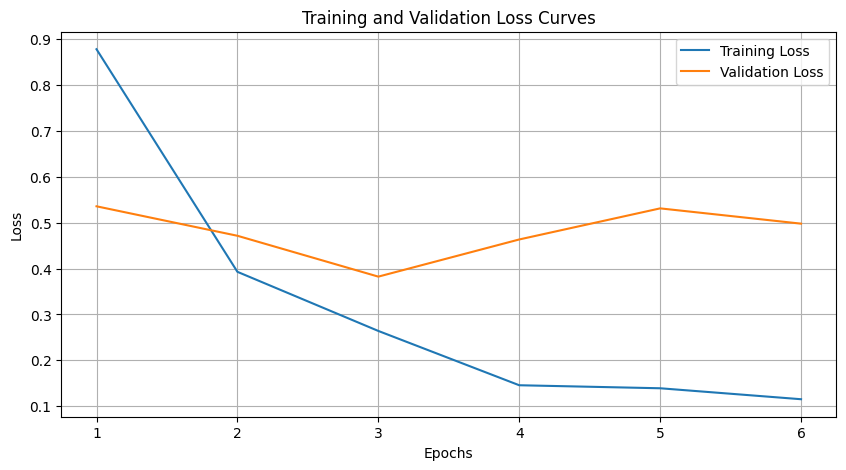

In [5]:
# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)



In [6]:
# Test model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    
    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate on test set
evaluate_model(model, test_loader)

Testing: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

Test Accuracy: 84.00%


# Efficient ViT

Link : https://github.com/mit-han-lab/efficientvit

Using device: cuda
Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaf', 'Mosaic Disease', 'Powdery Mildew']
Class-to-Index Mapping: {'Bacterial Leaf Spot': 0, 'Downy Mildew': 1, 'Healthy Leaf': 2, 'Mosaic Disease': 3, 'Powdery Mildew': 4}
Class Distribution: Counter({0: 400, 1: 400, 2: 400, 3: 400, 4: 400})
Train Dataset Size: 1400
Validation Dataset Size: 400
Test Dataset Size: 200


model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Epoch 1/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


Train Loss: 0.7898, Train Accuracy: 71.07%
Val Loss: 0.6491, Val Accuracy: 79.50%

Epoch 2/10


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.34it/s]


Train Loss: 0.2829, Train Accuracy: 90.71%
Val Loss: 0.4236, Val Accuracy: 84.00%

Epoch 3/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


Train Loss: 0.1560, Train Accuracy: 96.07%
Val Loss: 0.4735, Val Accuracy: 84.75%

Epoch 4/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


Train Loss: 0.0807, Train Accuracy: 98.50%
Val Loss: 0.3824, Val Accuracy: 87.75%

Epoch 5/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Train Loss: 0.0474, Train Accuracy: 99.43%
Val Loss: 0.4228, Val Accuracy: 86.00%

Epoch 6/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


Train Loss: 0.0291, Train Accuracy: 99.86%
Val Loss: 0.4574, Val Accuracy: 87.00%

Epoch 7/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


Train Loss: 0.0267, Train Accuracy: 99.86%
Val Loss: 0.4489, Val Accuracy: 83.50%

Early stopping triggered. Stopping training.


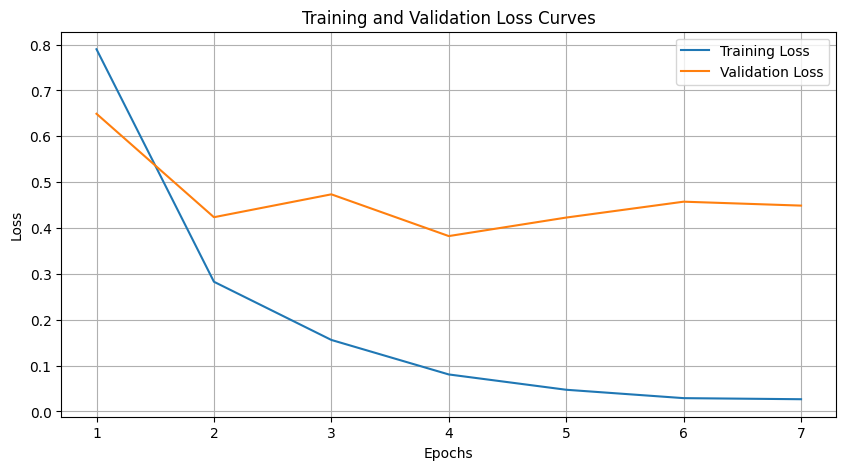

Testing: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

Test Accuracy: 87.50%


In [7]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from timm import create_model
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/pumpkin/Original/Original", transform=transform_train)

# Print dataset details
print("Classes:", dataset.classes)
print("Class-to-Index Mapping:", dataset.class_to_idx)

# Class distribution
labels = [sample[1] for sample in dataset.samples]
print("Class Distribution:", Counter(labels))

# Dataset split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformations
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# Verify split sizes
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load EfficientViT model
model = create_model('efficientvit_b0', pretrained=True, num_classes=len(dataset.classes))
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training and validation
num_epochs = 10
train_losses, val_losses = [], []

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=3)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_correct = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_acc = 100.0 * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100.0 * val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Test model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    
    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate on test set
evaluate_model(model, test_loader)


# ConViT: Improving Vision Transformers with Soft Convolutional Inductive Biases

## Using timm to use various Vision Transformer Base Models

In [10]:
import timm
models = timm.list_models('*vit*')
print(models)

['convit_base', 'convit_small', 'convit_tiny', 'crossvit_9_240', 'crossvit_9_dagger_240', 'crossvit_15_240', 'crossvit_15_dagger_240', 'crossvit_15_dagger_408', 'crossvit_18_240', 'crossvit_18_dagger_240', 'crossvit_18_dagger_408', 'crossvit_base_240', 'crossvit_small_240', 'crossvit_tiny_240', 'davit_base', 'davit_base_fl', 'davit_giant', 'davit_huge', 'davit_huge_fl', 'davit_large', 'davit_small', 'davit_tiny', 'efficientvit_b0', 'efficientvit_b1', 'efficientvit_b2', 'efficientvit_b3', 'efficientvit_l1', 'efficientvit_l2', 'efficientvit_l3', 'efficientvit_m0', 'efficientvit_m1', 'efficientvit_m2', 'efficientvit_m3', 'efficientvit_m4', 'efficientvit_m5', 'fastvit_ma36', 'fastvit_mci0', 'fastvit_mci1', 'fastvit_mci2', 'fastvit_s12', 'fastvit_sa12', 'fastvit_sa24', 'fastvit_sa36', 'fastvit_t8', 'fastvit_t12', 'flexivit_base', 'flexivit_large', 'flexivit_small', 'gcvit_base', 'gcvit_small', 'gcvit_tiny', 'gcvit_xtiny', 'gcvit_xxtiny', 'levit_128', 'levit_128s', 'levit_192', 'levit_256', 

Using device: cuda
Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaf', 'Mosaic Disease', 'Powdery Mildew']
Class-to-Index Mapping: {'Bacterial Leaf Spot': 0, 'Downy Mildew': 1, 'Healthy Leaf': 2, 'Mosaic Disease': 3, 'Powdery Mildew': 4}
Class Distribution: Counter({0: 400, 1: 400, 2: 400, 3: 400, 4: 400})
Train Dataset Size: 1400
Validation Dataset Size: 400
Test Dataset Size: 200


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Train Loss: 0.7826, Train Accuracy: 69.43%
Val Loss: 0.4396, Val Accuracy: 87.50%

Epoch 2/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Train Loss: 0.3650, Train Accuracy: 87.57%
Val Loss: 0.4799, Val Accuracy: 83.25%

Epoch 3/10


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


Train Loss: 0.2156, Train Accuracy: 92.29%
Val Loss: 0.3839, Val Accuracy: 87.00%

Epoch 4/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Train Loss: 0.0619, Train Accuracy: 98.43%
Val Loss: 0.4917, Val Accuracy: 85.25%

Epoch 5/10


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


Train Loss: 0.0158, Train Accuracy: 99.64%
Val Loss: 0.5209, Val Accuracy: 88.25%

Epoch 6/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

Train Loss: 0.0086, Train Accuracy: 99.71%
Val Loss: 0.5367, Val Accuracy: 86.75%

Early stopping triggered. Stopping training.


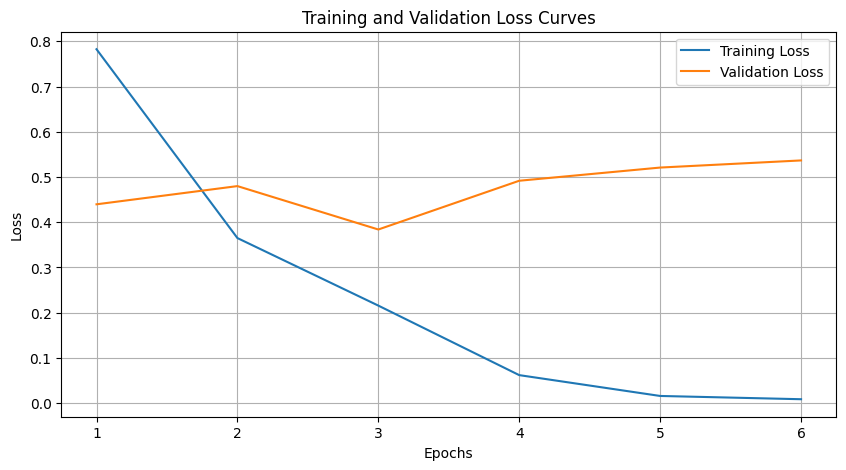

Testing: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

Test Accuracy: 87.00%


In [11]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from timm import create_model
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/pumpkin/Original/Original", transform=transform_train)

# Print dataset details
print("Classes:", dataset.classes)
print("Class-to-Index Mapping:", dataset.class_to_idx)

# Class distribution
labels = [sample[1] for sample in dataset.samples]
print("Class Distribution:", Counter(labels))

# Dataset split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformations
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# Verify split sizes
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load CvT model
model = create_model('convit_base', pretrained=True, num_classes=len(dataset.classes))
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training and validation
num_epochs = 10
train_losses, val_losses = [], []
early_stopping = EarlyStopping(patience=3)

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_correct = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_acc = 100.0 * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100.0 * val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Test model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    
    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate on test set
evaluate_model(model, test_loader)
